In [ ]:
! pip install human-learn delayed scikit-learn -Uqq

     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 


In [ ]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from hulearn.classification import FunctionClassifier
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Specimen field notes phenelogy analysis

This is just a few experiments to work out how to do predict plant phenology from the notes field of a herbarium specimen.

## Data

The training/evaluation data is a random sample of 1000 records that Jamie has labelled.

He's currently in the middle of labelling, so they're partially complete at the moment.

In [ ]:
uploaded = files.upload()

Saving training_dataset.csv to training_dataset.csv


In [ ]:
filename = "training_dataset.csv" # this must match the name of the file you uploaded
d = pd.read_csv(io.StringIO(uploaded[filename].decode("utf-8")))

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   family                  1000 non-null   object 
 1   genus                   1000 non-null   object 
 2   species                 1000 non-null   object 
 3   herbarium_id            1000 non-null   object 
 4   specimen_id             1000 non-null   object 
 5   field_number            1000 non-null   object 
 6   collectors              1000 non-null   object 
 7   collection_date         984 non-null    object 
 8   year                    984 non-null    float64
 9   month                   984 non-null    float64
 10  day                     984 non-null    float64
 11  locality                1000 non-null   object 
 12  latitude                899 non-null    float64
 13  longitude               900 non-null    float64
 14  elevation_min_(m)       919 non-null    f

We can see that all of the records have a `field_description`, as they should.

The label columns are `Flower` and `Fruit`, both of which are completed for 203 records. Which will do for now.

To get things into shape for this trial, we'll split the data into predictors and target, with `Flower` as the target.

In [ ]:
trial_df = (
    d.dropna(subset=["Flower"])
      .assign(Flower=lambda x: x.Flower == "Y")
)

X, y = trial_df.drop(columns=["Flower"]), trial_df["Flower"]

X.shape, y.shape

((203, 22), (203,))

## Predicting phenological state

The easiest thing to do is use a list of keywords to get back the phenelogical state.

We want to use cross-validation and maybe some standard pre-processing to evaluate how well our methods are working. There's a lot of functionality for this in the [`scikit-learn`](https://scikit-learn.org/) package.

To use our own rule-based classifier in this framework, we need to define our own [class of estimator](https://scikit-learn.org/stable/developers/develop.html). This is doable, but a bit of a pain.

Luckily, there's a really nice package called [`human-learn`](https://koaning.github.io/human-learn/) that has already implemented a class of estimator that [just accepts a function](https://koaning.github.io/human-learn/guide/function-classifier/function-classifier.html).

So all we need to do is define a function that classifies our data based on a list of keywords.

We'll define a function that accepts our dataframe, and a list of keywords.

This won't work for any dataframe that doesn't have a column `field_description`, but I think that's fine.

We're also splitting the descriptions into separate words, to make sure we aren't getting problems with suffixes and stuff.

In [ ]:
def keyword_based(df, keywords=None):
  if (keywords is None) or not isinstance(keywords, list):
    raise ValueError("You must provide a list of keywords")
    
  return df.field_description.str.split().apply(lambda x: any(word in x for word in keywords)).values.astype(int)

Now let's try this out with a few key words to make sure everything is working.

In [ ]:
keywords = ["flowers", "flower", "corolla", "calyx", "petals"]

keyword_based(X[:10], keywords=keywords)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The function works fine, so we can make our classifier out of it.

In [ ]:
keyword_clf = FunctionClassifier(keyword_based, keywords=keywords)

keyword_clf.fit(X, y).predict(X[:10])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The classifier works fine. 

As an aside, we do a `fit` step, but this doesn't actually do anything - we're not learning anything from the data. It's just convention - sklearn doesn't let you predict with a classifier that hasn't been fit.

Now we can run cross-validation and see what it's like.

In [ ]:
keyword_scores = cross_validate(keyword_clf, X, y, cv=5, scoring=["accuracy", "precision", "recall"])
keyword_scores

{'fit_time': array([0.00475335, 0.00277805, 0.00167084, 0.00148988, 0.00177526]),
 'score_time': array([0.00681901, 0.00252318, 0.00250554, 0.00266957, 0.00237226]),
 'test_accuracy': array([0.43902439, 0.51219512, 0.56097561, 0.525     , 0.45      ]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([0.04166667, 0.13043478, 0.2173913 , 0.17391304, 0.04347826])}

Pretty much as I'd expect - it's a small set of words that definitely indicate flowering, so we get all positive predictions right but we miss a fair number of things.

As a comparison, we'll also make a simple classifier that always predicts the most frequent class in the data.

In [ ]:
simple_clf = DummyClassifier(strategy="most_frequent", random_state=123)

simple_scores = cross_validate(simple_clf, X, y, cv=5, scoring=["accuracy", "precision", "recall"])
simple_scores

{'fit_time': array([0.00111794, 0.00152659, 0.0011282 , 0.0008564 , 0.00077224]),
 'score_time': array([0.00462556, 0.00477052, 0.00210881, 0.00198102, 0.00199914]),
 'test_accuracy': array([0.58536585, 0.56097561, 0.56097561, 0.575     , 0.575     ]),
 'test_precision': array([0.58536585, 0.56097561, 0.56097561, 0.575     , 0.575     ]),
 'test_recall': array([1., 1., 1., 1., 1.])}

And make a utility to put it in a nice table

In [ ]:
def format_cv_results(results, model_name="model"):
  results_df = (
    pd.DataFrame(results)
      .rename(columns=lambda x: x.replace("test_", ""))
      .assign(model=model_name,
              fold=lambda df: df.index.values)
      .drop(columns=["fit_time", "score_time"])
  )

  return results_df

cv_results = (
    pd.concat([format_cv_results(simple_scores, "most frequent"),
               format_cv_results(keyword_scores, "keywords") ])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

cv_results.head()

,model,fold,measure,score
0,most frequent,0,accuracy,0.585366
1,most frequent,1,accuracy,0.560976
2,most frequent,2,accuracy,0.560976
3,most frequent,3,accuracy,0.575000
4,most frequent,4,accuracy,0.575000


So we can do a boxplot of performance.

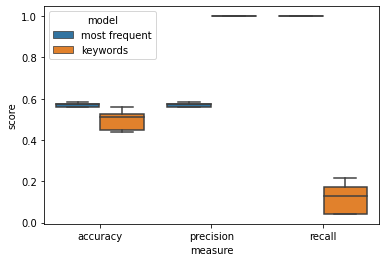

In [ ]:
sns.boxplot(x="measure", y="score", hue="model", data=cv_results)

Our keyword model is actually worse than just guessing "not flowering" for everything.

I think we can make a bit of an improvement if we just cast all our descriptions as lower case - "Flowers" probably comes at the beginning of the sentence a lot.

So let's redefine the function.

In [ ]:
def keyword_based(df, keywords=None, lower_case=False):
  if (keywords is None) or not isinstance(keywords, list):
    raise ValueError("You must provide a list of keywords")
  
  notes = df.field_description

  if lower_case:
    notes = notes.str.lower()
  
  words = notes.str.split()
  return words.apply(lambda x: any(word in x for word in keywords)).values.astype(int)

And re-run the classifier.

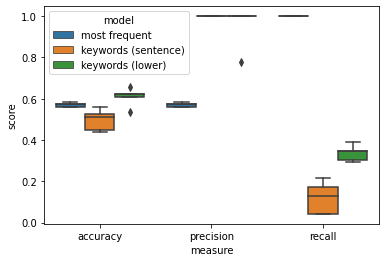

In [ ]:
keyword_lower_clf = FunctionClassifier(keyword_based, keywords=keywords, lower_case=True)

keyword_lower_scores = cross_validate(keyword_lower_clf, X, y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(simple_scores, "most frequent"),
               format_cv_results(keyword_scores, "keywords (sentence)"),
               format_cv_results(keyword_lower_scores, "keywords (lower)"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

sns.boxplot(x="measure", y="score", hue="model", data=cv_results)

Already better!

## Bag of words

Just searching for keywords is one way of doing it.

But the section of machine learning that focusses on text analysis (natural language processing) has well established ways of pre-processing text to make it easier to put it into models.

Because most machine learning models operate on numbers (they're all just a bunch of mathematical operations), one of the main pre-processing steps is converting a piece of text into a set of numbers.

This is called vectorisation.

One of the simplest vectorisation steps is splitting the text into individual words and counting up the how many times each word appears in each piece of text. This is called a "bag of words" because it's like throwing all the words in your training dataset into a bag.

This gives a matrix where each column is a word that appears in your training set, each row is an observation (here a specimen notes field), and each cell is the number of times a word appears in a particular observation.

`scikit-learn` has a simple implementation of this called `CountVectorizer`. This also has the advantage of doing some other simple pre-processing by default - it makes everything lower case, automatically removes words that appear in every single example, and removes punctuation. There are some other text processing things we might want to do at a later stage, but for now this will work as a starting point.

After creating the vectoriser, we fit it to our training data. This lets the vectoriser know what words are in our bag. We can fit it and transform our training data in a single step using `fit_transform`.

In [ ]:
count_vct = CountVectorizer()
X_counts = count_vct.fit_transform(X.field_description.values)
X_counts.shape

(203, 637)

This creates a special sparse-matrix type. But we want to use this bag of words to try our keyword method as well, so everything is looking at the same set of data.

So we'll make a dataframe out of it. This might cause memory issues if we had a massive corpus.

In [ ]:
X_counts_df = pd.DataFrame(X_counts.toarray(), columns=count_vct.get_feature_names())
X_counts_df.iloc[:10, :10]

,10,100,12,15,1m,20,20m,25,30,3300
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


Now we can redefine our keyword function to accept this dataframe. It will just check if any values in columns corresponding to our keywords are greater than 0.

In [ ]:
def keyword_tokens_based(df, keywords=None):
  return df.loc[:, df.columns.isin(keywords)].any(axis=1).values.astype(int)

keyword_tokens_based(X_counts_df.head(10), keywords)

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

And then we can check the performance with this new method - realising the difference will be the extra pre-processing steps the vectoriser uses.

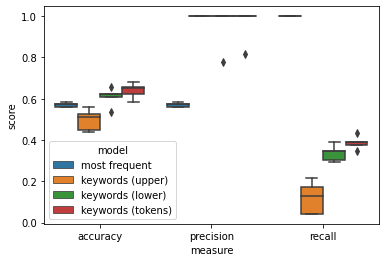

In [ ]:
keyword_token_clf = FunctionClassifier(keyword_tokens_based, keywords=keywords)

keyword_token_scores = cross_validate(keyword_token_clf, X_counts_df, y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(simple_scores, "most frequent"),
               format_cv_results(keyword_scores, "keywords (upper)"),
               format_cv_results(keyword_lower_scores, "keywords (lower)"),
               format_cv_results(keyword_token_scores, "keywords (tokens)"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

sns.boxplot(x="measure", y="score", hue="model", data=cv_results)

## Machine learning

We can use our bag of words as input to machine learning models.

We'll try a simple naive bayes to start with.

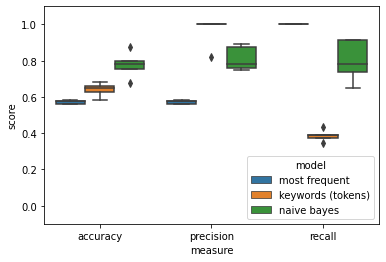

In [ ]:
nb_clf = GaussianNB()

nb_scores = cross_validate(nb_clf, X_counts.toarray(), y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(simple_scores, "most frequent"),
               format_cv_results(keyword_token_scores, "keywords (tokens)"),
               format_cv_results(nb_scores, "naive bayes"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results, ax=ax)

ax.set_ylim((-0.1, 1.1));

And then we can try a random forest model. Typically this might need some parameter tuning, but usually works well out of the box.


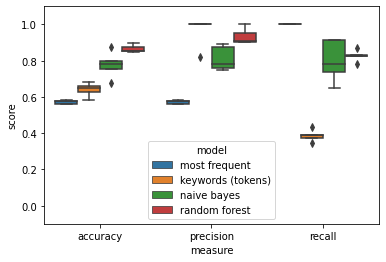

In [ ]:
rf_clf = RandomForestClassifier()

rf_scores = cross_validate(rf_clf, X_counts.toarray(), y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(simple_scores, "most frequent"),
               format_cv_results(keyword_token_scores, "keywords (tokens)"),
               format_cv_results(nb_scores, "naive bayes"),
               format_cv_results(rf_scores, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results, ax=ax)

ax.set_ylim((-0.1, 1.1));

One nice thing about random forest classifiers is we can use feature importance to get an idea of which words are most important to the performance of the classifier.

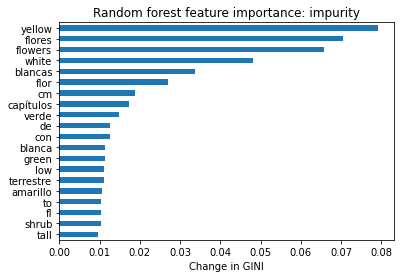

In [ ]:
rf_clf.fit(X_counts.toarray(), y)

fig, ax = plt.subplots()
pd.Series(rf_clf.feature_importances_, index=count_vct.get_feature_names()).sort_values(ascending=False).head(20).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Change in GINI")
ax.set_title("Random forest feature importance: impurity");

In [ ]:
from nltk.corpus import stopwords
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk

In [ ]:
stopwords.words("english")[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
stopwords.words("spanish")[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [ ]:
X_counts_df.columns[X_counts_df.columns.isin(stopwords.words("english"))]

Index(['above', 'against', 'an', 'and', 'are', 'at', 'be', 'below', 'but',
       'few', 'for', 'from', 'in', 'is', 'it', 'more', 'most', 'no', 'of',
       'on', 'only', 'or', 'over', 'some', 'than', 'the', 'to', 'up', 'very',
       'when', 'with'],
      dtype='object')

In [ ]:
X_counts_df.columns[X_counts_df.columns.isin(stopwords.words("spanish"))]

Index(['antes', 'con', 'de', 'del', 'donde', 'el', 'en', 'entre', 'es', 'la',
       'las', 'les', 'los', 'muy', 'más', 'no', 'para', 'poco', 'que', 'se',
       'sin', 'son', 'sus', 'una', 'unos'],
      dtype='object')

In [ ]:
X_counts_df.columns[X_counts_df.columns.isin(stopwords.words("german"))]

Index(['an', 'des', 'es', 'in'], dtype='object')

In [ ]:
X_counts_df.columns[X_counts_df.columns.isin(stopwords.words("french"))]

Index(['avec', 'de', 'des', 'en', 'es', 'et', 'la', 'les', 'même', 'on', 'par',
       'que', 'se', 'son', 'sur', 'étant'],
      dtype='object')

In [ ]:
stop_words = stopwords.words("french") + stopwords.words("english") + stopwords.words("spanish")
count_vct_stops = CountVectorizer(stop_words=stop_words)

X_counts_stop = count_vct_stops.fit_transform(X.field_description.values)
X_counts_stop.shape

(203, 575)

In [ ]:
X_counts_stop_df = pd.DataFrame(X_counts_stop.toarray(), columns=count_vct_stops.get_feature_names())
X_counts_stop_df.iloc[:10, :10]

,10,100,12,15,1m,20,20m,25,30,3300
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


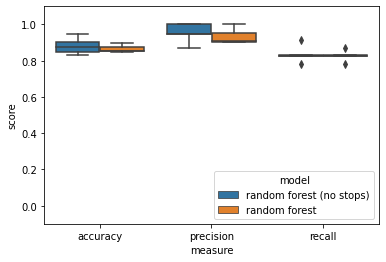

In [ ]:
rf_stops_clf = RandomForestClassifier()
rf_stops_scores = cross_validate(rf_stops_clf, X_counts_stop.toarray(), y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(rf_stops_scores, "random forest (no stops)"),
               format_cv_results(rf_scores, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results, ax=ax)

ax.set_ylim((-0.1, 1.1));

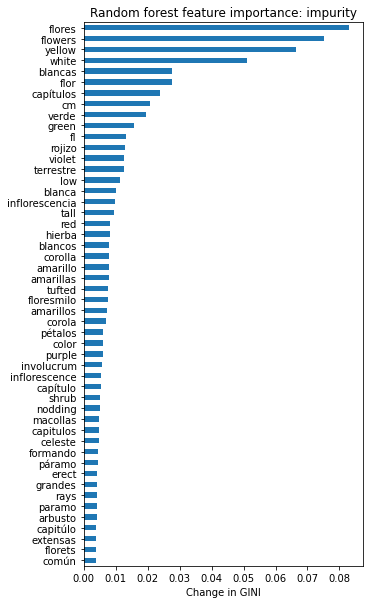

In [ ]:
rf_stops_clf.fit(X_counts_stop.toarray(), y)

fig, ax = plt.subplots(figsize=(5,10))
pd.Series(rf_stops_clf.feature_importances_, index=count_vct_stops.get_feature_names()).sort_values(ascending=False).head(50).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Change in GINI")
ax.set_title("Random forest feature importance: impurity");

In [ ]:
count_vct_binary = CountVectorizer(binary=True)

X_counts_binary = count_vct_binary.fit_transform(X.field_description.values)
X_counts_binary.shape

(203, 637)

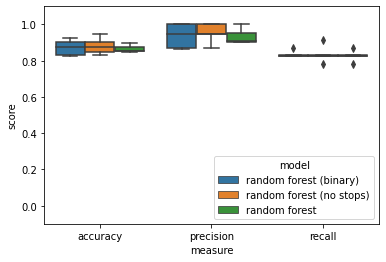

In [ ]:
rf_binary_clf = RandomForestClassifier()
rf_binary_scores = cross_validate(rf_binary_clf, X_counts_binary.toarray(), y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(rf_binary_scores, "random forest (binary)"),
               format_cv_results(rf_stops_scores, "random forest (no stops)"),
               format_cv_results(rf_scores, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results, ax=ax)

ax.set_ylim((-0.1, 1.1));

In [ ]:
count_vct_bi_uni = CountVectorizer(binary=True, ngram_range=(1,2))

X_counts_bi_uni = count_vct_bi_uni.fit_transform(X.field_description.values)
X_counts_bi_uni.shape

(203, 1737)

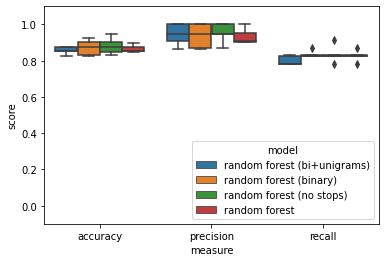

In [ ]:
rf_biuni_clf = RandomForestClassifier()
rf_biuni_scores = cross_validate(rf_biuni_clf, X_counts_bi_uni.toarray(), y, cv=5, scoring=["accuracy", "precision", "recall"])

cv_results = (
    pd.concat([format_cv_results(rf_biuni_scores, "random forest (bi+unigrams)"),
               format_cv_results(rf_binary_scores, "random forest (binary)"),
               format_cv_results(rf_stops_scores, "random forest (no stops)"),
               format_cv_results(rf_scores, "random forest"),])
      .melt(id_vars=["model", "fold"], var_name="measure", value_name="score")
)

fig, ax = plt.subplots()

sns.boxplot(x="measure", y="score", hue="model", data=cv_results, ax=ax)

ax.set_ylim((-0.1, 1.1));

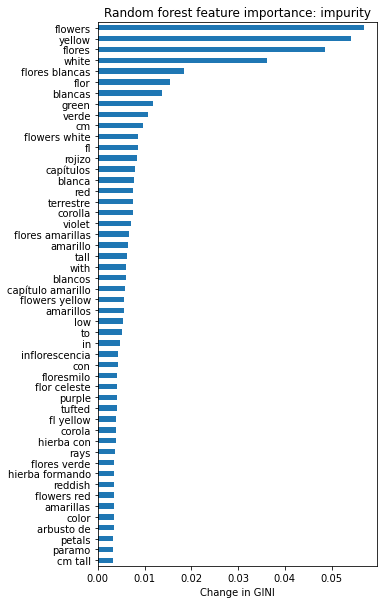

In [ ]:
rf_biuni_clf.fit(X_counts_bi_uni.toarray(), y)

fig, ax = plt.subplots(figsize=(5,10))
pd.Series(rf_biuni_clf.feature_importances_, index=count_vct_bi_uni.get_feature_names()).sort_values(ascending=False).head(50).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Change in GINI")
ax.set_title("Random forest feature importance: impurity");

## Actually doing the process including permuation feature importance

In [ ]:
def sparse_to_df(sparse, col_names=None):
  return pd.DataFrame(sparse.toarray(), columns=col_names)

In [ ]:
simple_pipe = Pipeline([
                        ("vect", CountVectorizer()),
                        ("clf", DummyClassifier(strategy="most_frequent"))
])

keyword_pipe = Pipeline([
                         ("vect", CountVectorizer(vocabulary=keywords)),
                         ("to_df", FunctionTransformer(lambda x: sparse_to_df(x, col_names=keywords))),
                         ("clf", FunctionClassifier(keyword_tokens_based, keywords=keywords))
])

rf_pipe = Pipeline([
                         ("vect", CountVectorizer()),
                         ("clf", RandomForestClassifier())
])

NameError: ignored

In [ ]:
rf_pipe = Pipeline([
                         ("vect", CountVectorizer()),
                         ("clf", RandomForestClassifier())
])

In [ ]:
rf_pipe["vect"]

CountVectorizer()

In [ ]:
cross_validate(simple_pipe, X.field_description.values, y, scoring=["accuracy", "precision", "recall"])

{'fit_time': array([0.00577021, 0.00291085, 0.00292683, 0.00280571, 0.00287557]),
 'score_time': array([0.00410628, 0.00281453, 0.00240588, 0.00271869, 0.00253367]),
 'test_accuracy': array([0.58536585, 0.56097561, 0.56097561, 0.575     , 0.575     ]),
 'test_precision': array([0.58536585, 0.56097561, 0.56097561, 0.575     , 0.575     ]),
 'test_recall': array([1., 1., 1., 1., 1.])}

In [ ]:
cross_validate(keyword_pipe, X.field_description.values, y, scoring=["accuracy", "precision", "recall"])

{'fit_time': array([0.0069139 , 0.00290799, 0.00274181, 0.0027082 , 0.0028758 ]),
 'score_time': array([0.00474143, 0.00327301, 0.00336552, 0.00332022, 0.00362468]),
 'test_accuracy': array([0.58536585, 0.68292683, 0.65853659, 0.625     , 0.65      ]),
 'test_precision': array([0.81818182, 1.        , 1.        , 1.        , 1.        ]),
 'test_recall': array([0.375     , 0.43478261, 0.39130435, 0.34782609, 0.39130435])}

In [ ]:
cross_validate(rf_pipe, X.field_description.values, y, scoring=["accuracy", "precision", "recall"])

{'fit_time': array([0.15636635, 0.14296675, 0.14553308, 0.14433122, 0.16540647]),
 'score_time': array([0.01286864, 0.01207185, 0.01599598, 0.01189375, 0.013376  ]),
 'test_accuracy': array([0.85365854, 0.90243902, 0.85365854, 0.825     , 0.925     ]),
 'test_precision': array([0.90909091, 1.        , 0.9047619 , 0.86363636, 1.        ]),
 'test_recall': array([0.83333333, 0.82608696, 0.82608696, 0.82608696, 0.86956522])}

In [ ]:
cv = ShuffleSplit(n_splits=5)

In [ ]:
cv.split(X.field_description.values)

<generator object BaseShuffleSplit.split at 0x7f52a3969e50>

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
cv = KFold(n_splits=5, shuffle=True)

In [ ]:
[(train.shape, test.shape) for (train, test) in cv.split(X)]

[((162,), (41,)),
 ((162,), (41,)),
 ((162,), (41,)),
 ((163,), (40,)),
 ((163,), (40,))]

In [ ]:
scores = []
for train_idx, test_idx in cv.split(X):
  X_train, X_test = X.field_description.values[train_idx], X.field_description.values[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]
  fit = rf_pipe.fit(X_train, y_train)
  scores.append(fit.score(X_test, y_test))

scores
  

[0.9024390243902439, 0.9024390243902439, 0.8780487804878049, 0.925, 0.8]

In [ ]:
?fit.score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
scores = []
for train_idx, test_idx in cv.split(X):
  X_train, X_test = X.field_description.values[train_idx], X.field_description.values[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]
  fit = rf_pipe.fit(X_train, y_train)
  pred = fit.predict(X_test)
  scores.append({
      "accuracy": accuracy_score(y_test, pred),
      "precision": precision_score(y_test, pred),
      "recall": recall_score(y_test, pred)
  })

pd.DataFrame(scores)
  

,accuracy,precision,recall
0,0.926829,1.000000,0.884615
1,0.926829,1.000000,0.869565
2,0.853659,0.960000,0.827586
3,0.800000,0.894737,0.739130
4,0.875000,0.812500,0.866667
